# EMBEDDING of OOV WORDS
This notebook address the problem of defining the embedding for words out of the considered vocabulary. The terms missing from the GloVe dictionary are indeed lacking a latent representation and therefore require an additional step.

$$
X_r \overset{SVD}{=} \underset{M \times M}{U} \underset{M \times N}{\Sigma} \underset{N \times N}{V^T}
$$

The following method performs Latent Semantic Analysis to retrieve the set of $K$-most semantically similar terms to each of the OOV words starting from their
TF-IDF representations $X$. Such a similarity measure is computed as the cosine similarity between their $r$-ranked approximation as follows:
$$
\text{sim}(w_i, w_j) = \cos (w_i \Sigma_r, w_j \Sigma_r) =\frac{(w_i \Sigma_r)(w_j \Sigma_r)^T}{\lVert w_i \Sigma_r \rVert \cdot \lVert w_j \Sigma_r \rVert} 
$$

### DATASETS LOADING
We are going to load the Glove embedding for every term of each dataset. Please note that, in order to keep the independency between training and testing instances, the similarity analysis is carried out over each set separately.

In [ ]:
install.packages('urltools')
install.packages("lsa")
install.packages("tm")
install.packages("RWeka")
install.packages('readr')
install.packages("reticulate")

library(urltools)
library(tm)
library(lsa)
library(RWeka)
library(readr)
library(reticulate)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘triebeard’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘SnowballC’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘NLP’, ‘slam’, ‘BH’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RWekajars’, ‘rJava’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’


Loading required package: NLP

Loading required package: SnowballC



In [ ]:
pd <- import("pandas")

train_val_oov <- pd$read_pickle('train_val_oov.pkl')
test_oov <- pd$read_pickle('test_oov.pkl')

In [ ]:
cat("Number of OOV words in train-validation:",length(train_val_oov),'\n')
cat("Number of OOV words in test:",length(test_oov),'\n')

Number of OOV words in train-validation: 548 
Number of OOV words in test: 161 


In [ ]:
train_val_data <- read.csv(file = 'train_val_tf.csv', row.names = 1, header= TRUE)
colnames(train_val_data) <- 1:ncol(train_val_data)
tf_idf_train_val <- as.matrix(train_val_data)
head(tf_idf_train_val)

,1,2,3,4,5,6,7,8,9,10,⋯,141,142,143,144,145,146,147,148,149,150
,0.03125,0,0.03846154,0.03874092,0.03508772,0.02222222,0.04054054,0.0390625,0.03658537,0.0419426,⋯,0.04220183,0.04133739,0.01639344,0.03111111,0.03184713,0.03282276,0.02479339,0.03475936,0.03819444,0.04651163
network,0.00000,0,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.0000000,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
exceed,0.00000,0,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.0000000,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
incurred,0.00000,0,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.0000000,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
hallett,0.00000,0,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.0000000,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
charities,0.00000,0,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.0000000,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [ ]:
test_data <- read.csv(file = 'test_tf.csv', row.names = 1, header= TRUE)
colnames(test_data) <- 1:ncol(test_data)
tf_idf_test <- as.matrix(test_data)
head(tf_idf_test)

,1,2,3,4,5,6,7,8,9,10,⋯,40,41,42,43,44,45,46,47,48,49
,0.030837,0.038709677,0.0368932,0.02816901,0.03996983,0.03191489,0.03030303,0.03855422,0.03755869,0.02684564,⋯,0.04651163,0,0.04051447,0.02,0.03571429,0,0,0,0.02906977,0.04651163
jihad,0.000000,0.000000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0,0.00000000,0.00,0.00000000,0,0,0,0.00000000,0.00000000
veto,0.000000,0.000000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0,0.00000000,0.00,0.00000000,0,0,0,0.02906977,0.00000000
popular,0.000000,0.000000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0,0.00000000,0.00,0.00000000,0,0,0,0.00000000,0.00000000
network,0.000000,0.006451613,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0,0.00000000,0.04,0.00000000,0,0,0,0.00000000,0.00000000
derchin,0.000000,0.000000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0,0.00000000,0.00,0.00000000,0,0,0,0.00000000,0.00000000


## EMBEDDING DEFINITION
The embedding of OOV words is considered as the average over the representations of the $K$-most similar words in the considered set. Given the OOV word $w_i$, its embedding representation is computed as
$$
\varepsilon_{w_i} = {avg}_{k \in \text{top-sim}(w_i)} ɛ_{w_k}
$$
being $ɛ_{w_j}$ the embedding representation of the word $w_j$. In this case, we shall consider $K = 10$. 

As the following analysis will show, to better exploit the distribution and the variability of representations, we shall consider only the $2^{nd}$ and $3^{th}$ singular values for the approximation of terms and documents. While excluding "lower hierarchy" variables helps to reduce the amount of less useful information, the removal of the most significant dimension is aimed at preventing the first dimensionality from biasing the representation and predominating over the effect of other variables showing more variability, and therefore more useful for the classification.

In [ ]:
read_oov <- function(file_name){
  x <- read.csv(file_name)
  return (x$X0)
}

find_10_most_similar <- function(x, term_lsa_eig) {
  similar <- associate(term_lsa_eig[,2:3], x, threshold=0.2)[1:10]
  return (similar)
}

Let us now perform LSA on each matrix separately. Before carrying out the decomposition, the vectors are normalized by way of the function `normalize`.

In [ ]:
normalize <- function(x) sqrt(sum(x^2))

# normalize each item
norm_train_val <- apply(tf_idf_train_val, 1, normalize)
norm_test <- apply(tf_idf_test, 1, normalize)

### LSA - TRAIN & VALIDATION SETS

In [ ]:
train_val_words <- rownames(tf_idf_train_val)

In [ ]:
lsa_tr_val = lsa(tf_idf_train_val)
cat("Number of selected eigenvectors ", length(lsa_tr_val$sk))

Number of selected eigenvectors  35

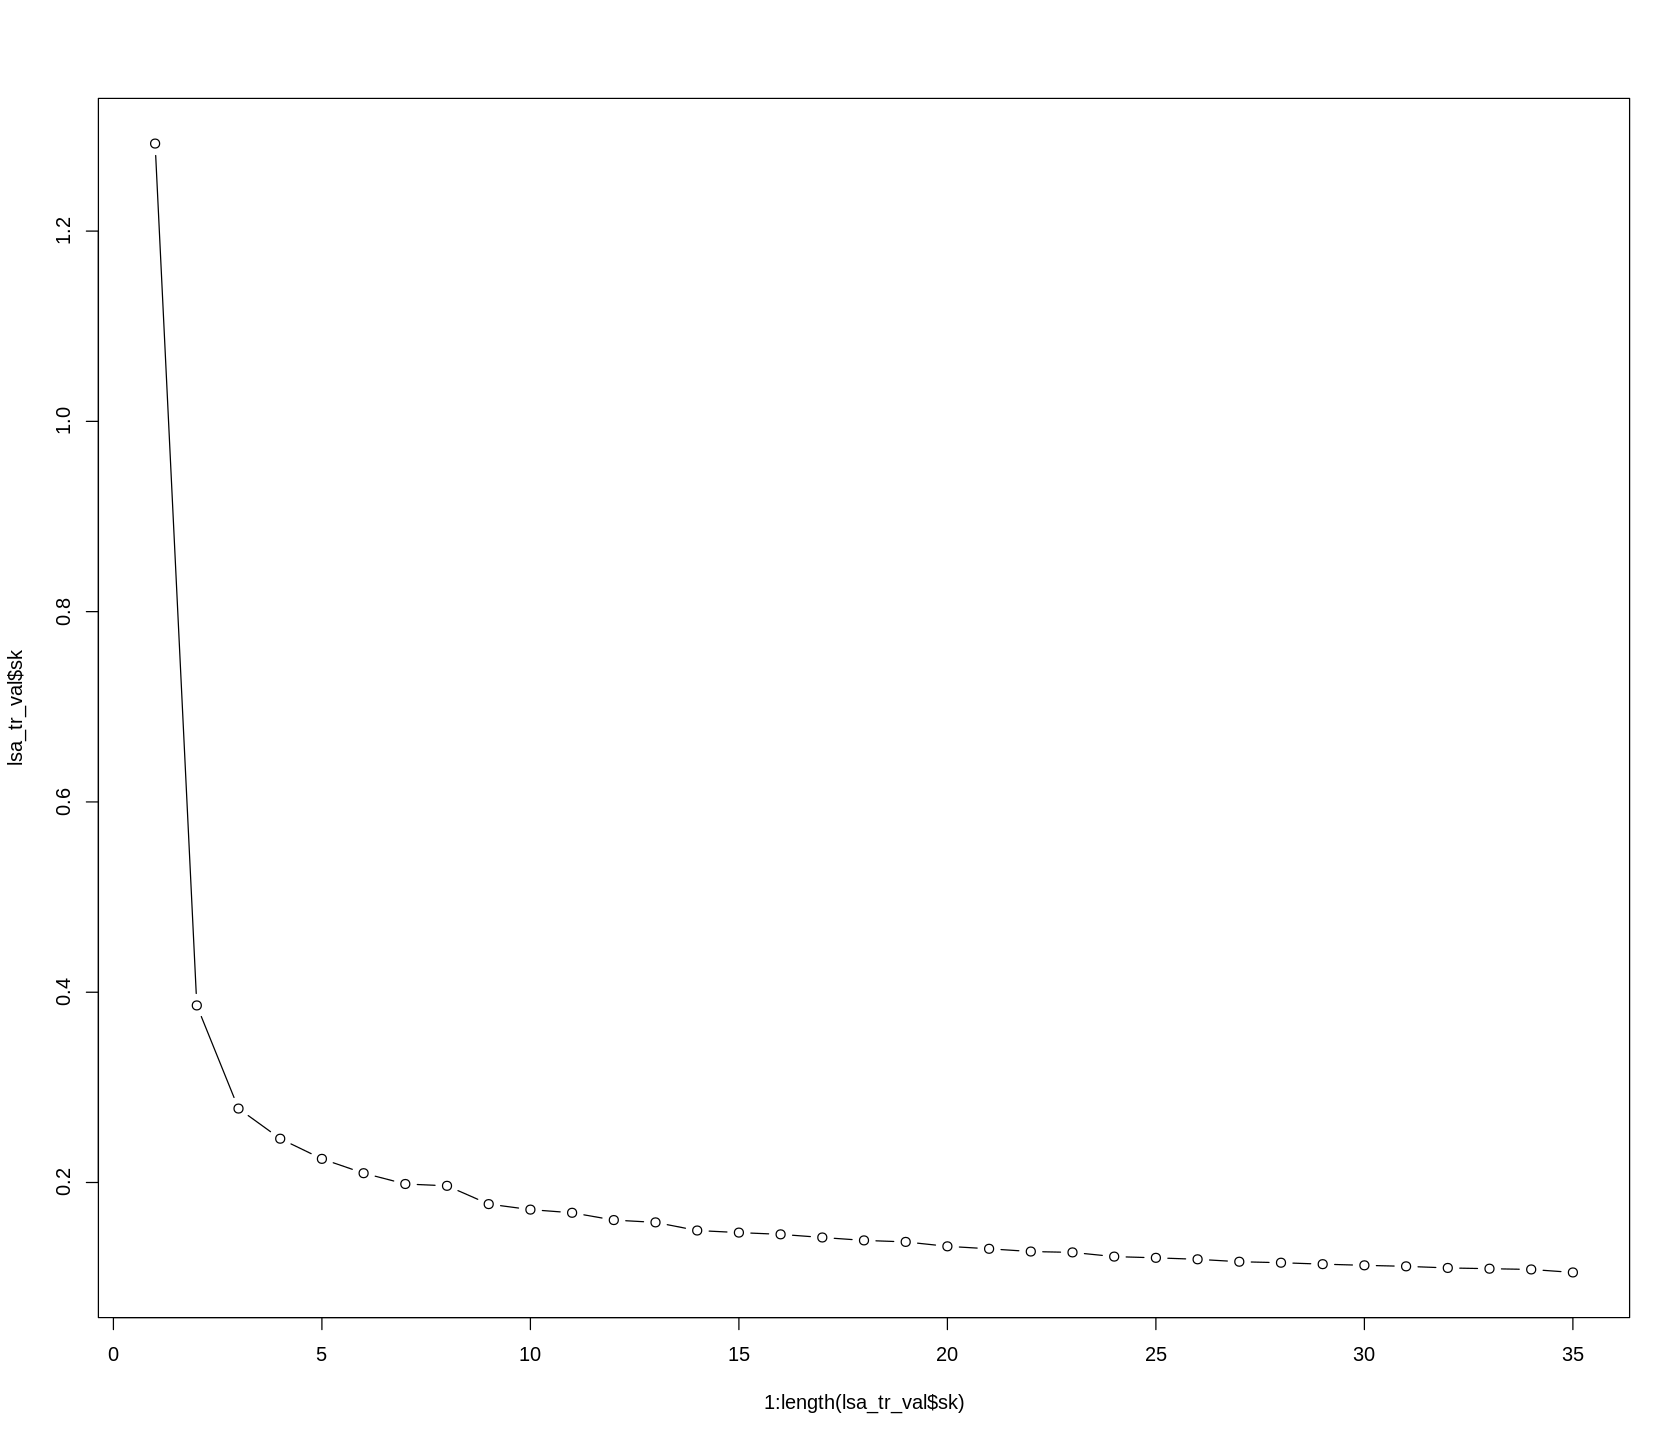

In [ ]:
plot(1:length(lsa_tr_val$sk), lsa_tr_val$sk, type='b')

Considering the approximation defined by the retrieved eigenvector shown in the above figure, the representation of terms and documents mapped into the latent space are computed as follows:
$$
t^{(i)} = u_r^{(i)} \cdot \Sigma_r\,, \qquad
d^{(j)} = v_r^{(j)} \cdot \Sigma_r
$$
with $u_r^{(k)}$ and $v_r^{(k)}$ being the instances of the considered term or document from the matrices $U_r$ and $V_r^T$, respectively.

In [ ]:
term_lsa <-lsa_tr_val$tk %*% diag(lsa_tr_val$sk)
doc_lsa <- lsa_tr_val$dk %*% diag(lsa_tr_val$sk)

In [ ]:
# compute the norm of each term
norma_termini_lsa_tr_val <- apply(term_lsa, 1, normalize)

norm_ids <- length(lsa_tr_val$sk) + 1 # column in which it is stored the norm value
tag_ids <- 1 

# build the apposite structures
tls_norma_termini_tr_val = cbind(term_lsa, norma_termini_lsa_tr_val)
tls_words_tag = cbind(train_val_words, norma_termini_lsa_tr_val)

meaning_threshold <- 0.05
meaningful_terms <- subset(tls_norma_termini_tr_val, norma_termini_lsa_tr_val > meaning_threshold)[,-norm_ids]
meaningful_words <- subset(tls_words_tag, norma_termini_lsa_tr_val > meaning_threshold)[,tag_ids]

For the sake of clarity, we shall consider only the most meaningful terms and documents, namely those with a higher norm value. The mapping of the latent representations of such subsets in the figure below shows the frequency and importance of terms in the considered dataset.

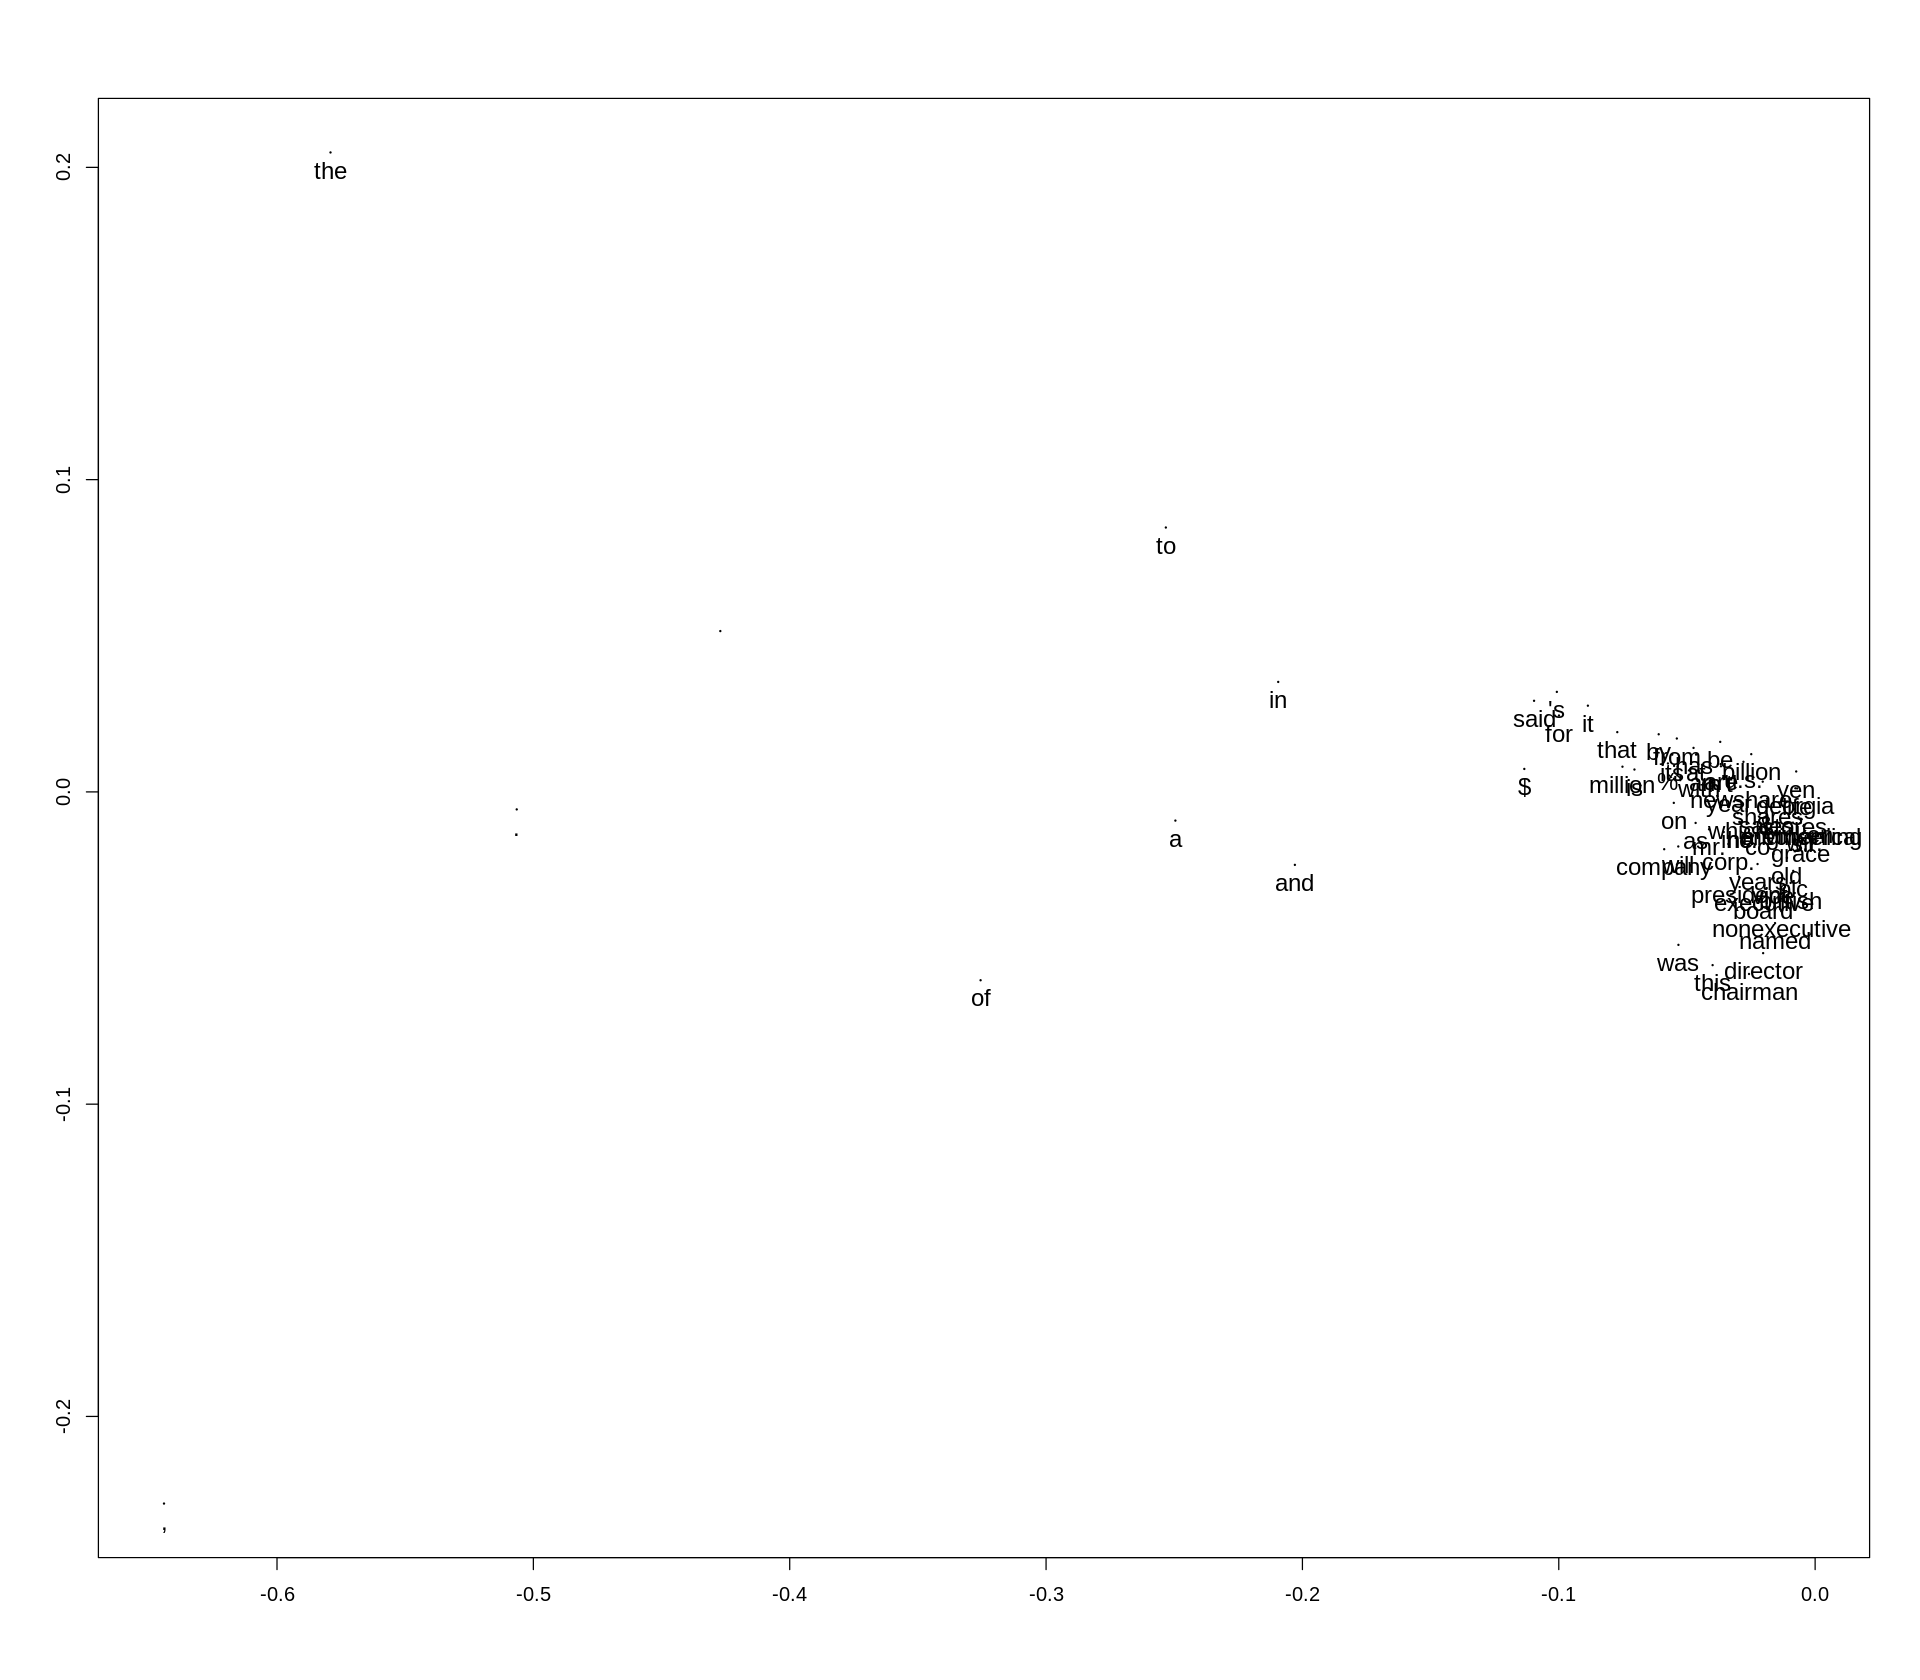

In [ ]:
options(repr.plot.width=16, repr.plot.height=14)
plot( meaningful_terms, pch=20, cex= 0.2)
text( meaningful_terms, labels=meaningful_words, cex=1.2, pos=1)

The plot below shows the distribution of documents in the approximate latent space.

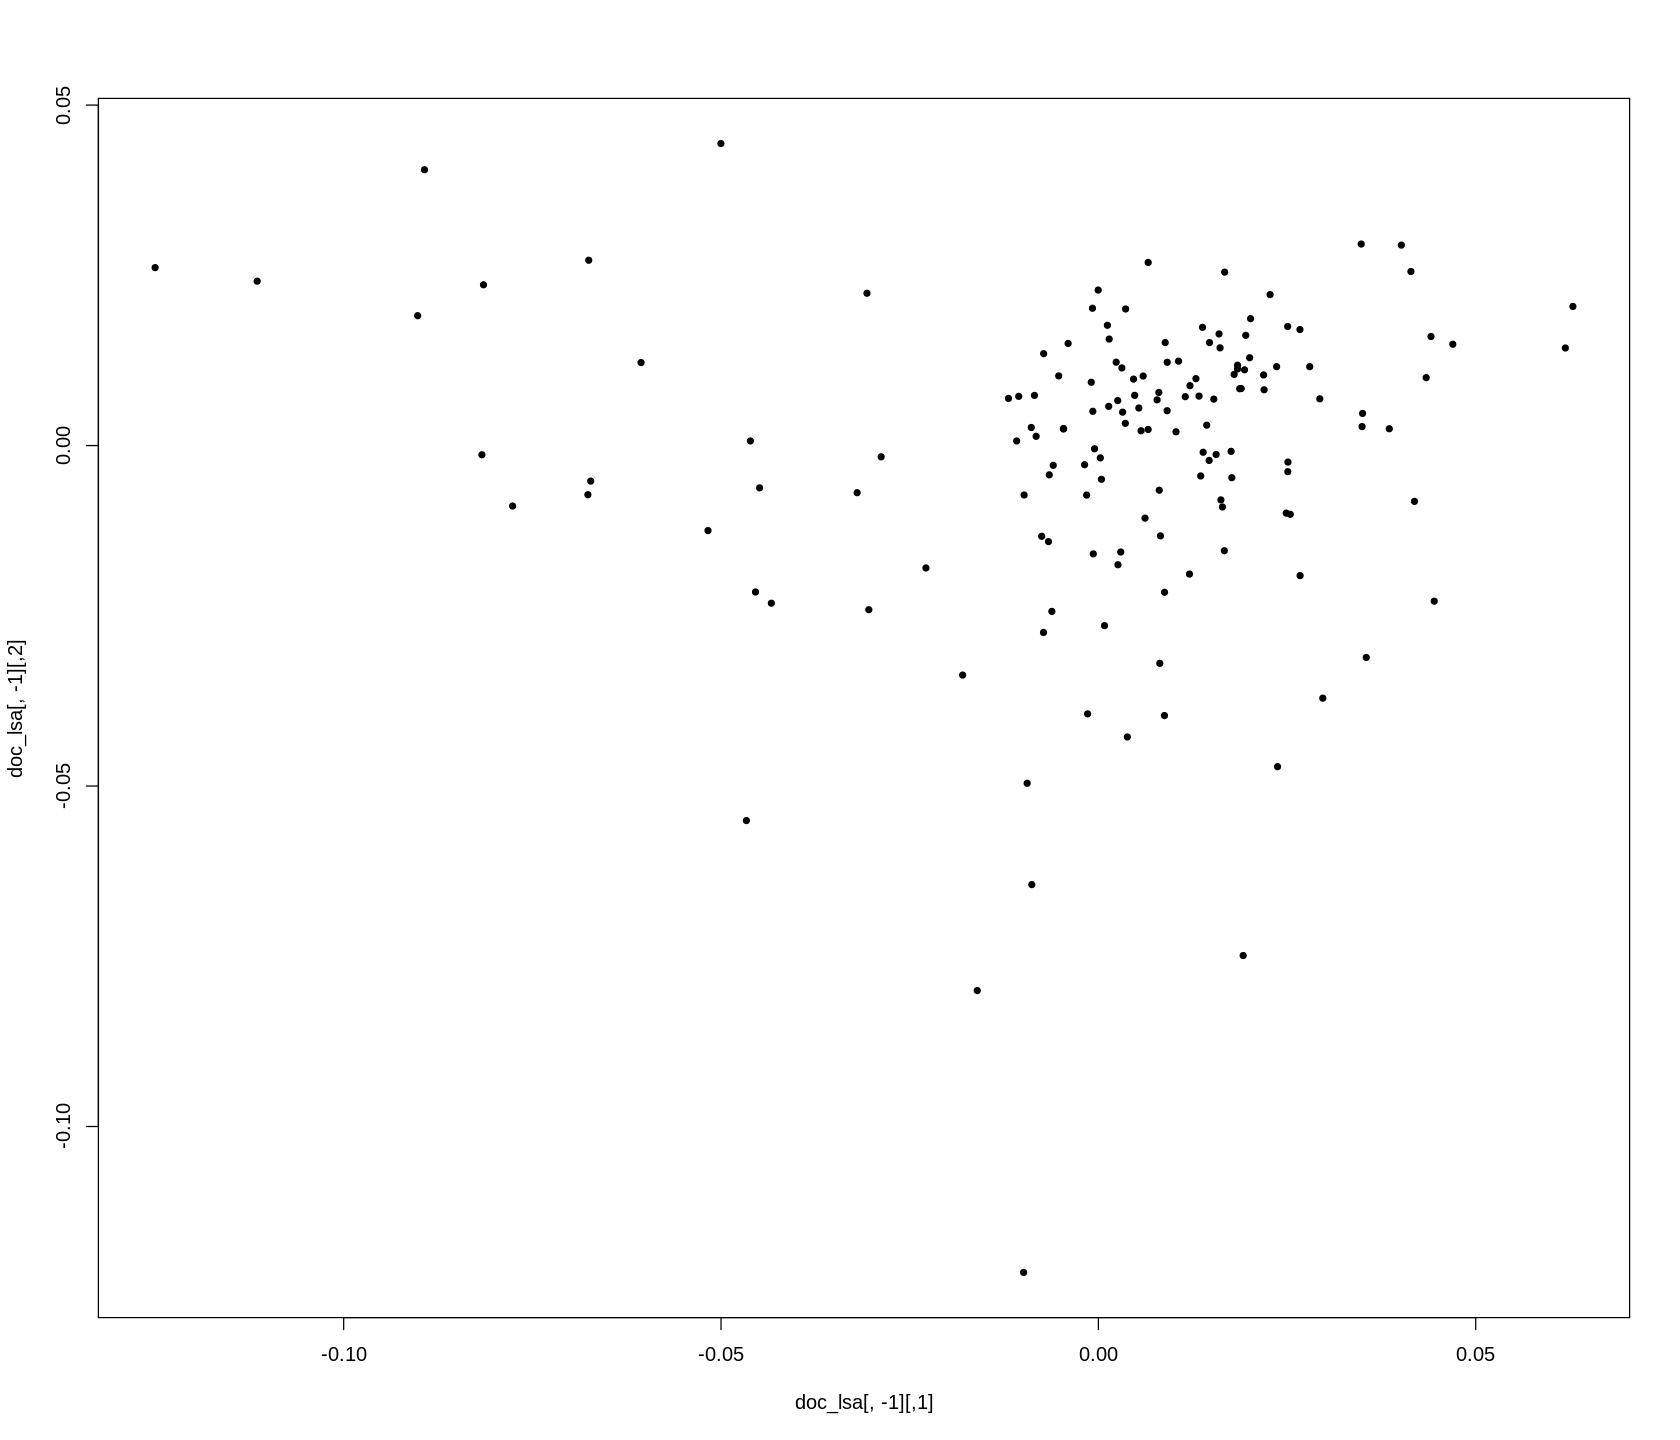

In [ ]:
options(repr.plot.width=14, repr.plot.height=12)
plot( doc_lsa[,-1], pch=20 ) # -1 removes the first latent dimensions in order to display the 2° and the 3°

Let us now find the $10$ most similar words for each term in the dataset

In [ ]:
train_val_oov <- read_oov('oov_train_val.csv')
tv_oov_similarities <- lapply(train_val_oov,find_10_most_similar,term_lsa)

In [ ]:
head(tv_oov_similarities)

[[1]]
         otc      bancorp         wfrr   lackluster           ed  beneficiary 
           1            1            1            1            1            1 
london-based     pennview   centerbank  fluctuation 
           1            1            1            1 

[[2]]
 stock-price   performers         akin     clannish    locations       broker 
           1            1            1            1            1            1 
     thunder   abolishing millionaires       merits 
           1            1            1            1 

[[3]]
       -rcb-       return     marshall         live         seem      dorothy 
   1.0000000    0.9999995    0.9999987    0.9999983    0.9999978    0.9999871 
     alleged      messrs.      centers odd-sounding 
   0.9999860    0.9999811    0.9999786    0.9999764 

[[4]]
         otc      bancorp         wfrr   lackluster           ed  beneficiary 
           1            1            1            1            1            1 
london-based   centerbank  fluctuation      achieve 
           1            1            1            1 

[[5]]
            softer               1.92              deere           start-up 
                 1                  1                  1                  1 
              wis.                4.5              352.9 larger-than-normal 
                 1                  1                  1                  1 
             truck            oshkosh 
                 1                  1 

[[6]]
    roofs  minivans rear-seat     belts therefore  unloaded    urging headrests 
        1         1         1         1         1         1         1         1 
      cab      rear 
        1         1

In [ ]:
csv_format = as.matrix(unlist(tv_oov_similarities), nrow = len(train_val_oov))
capture.output(csv_format, file = "train_val_oov_similarities.csv")

### LSA - TEST SET
Similarly, the process is applied to the words in the test set for which the analysis is carried out independently from the previous sets.

In [ ]:
test_words <- rownames(tf_idf_test)

In [ ]:
lsa_test = lsa(tf_idf_test)
cat("Number of selected eigenvectors ", length(lsa_test$sk))

Number of selected eigenvectors  12

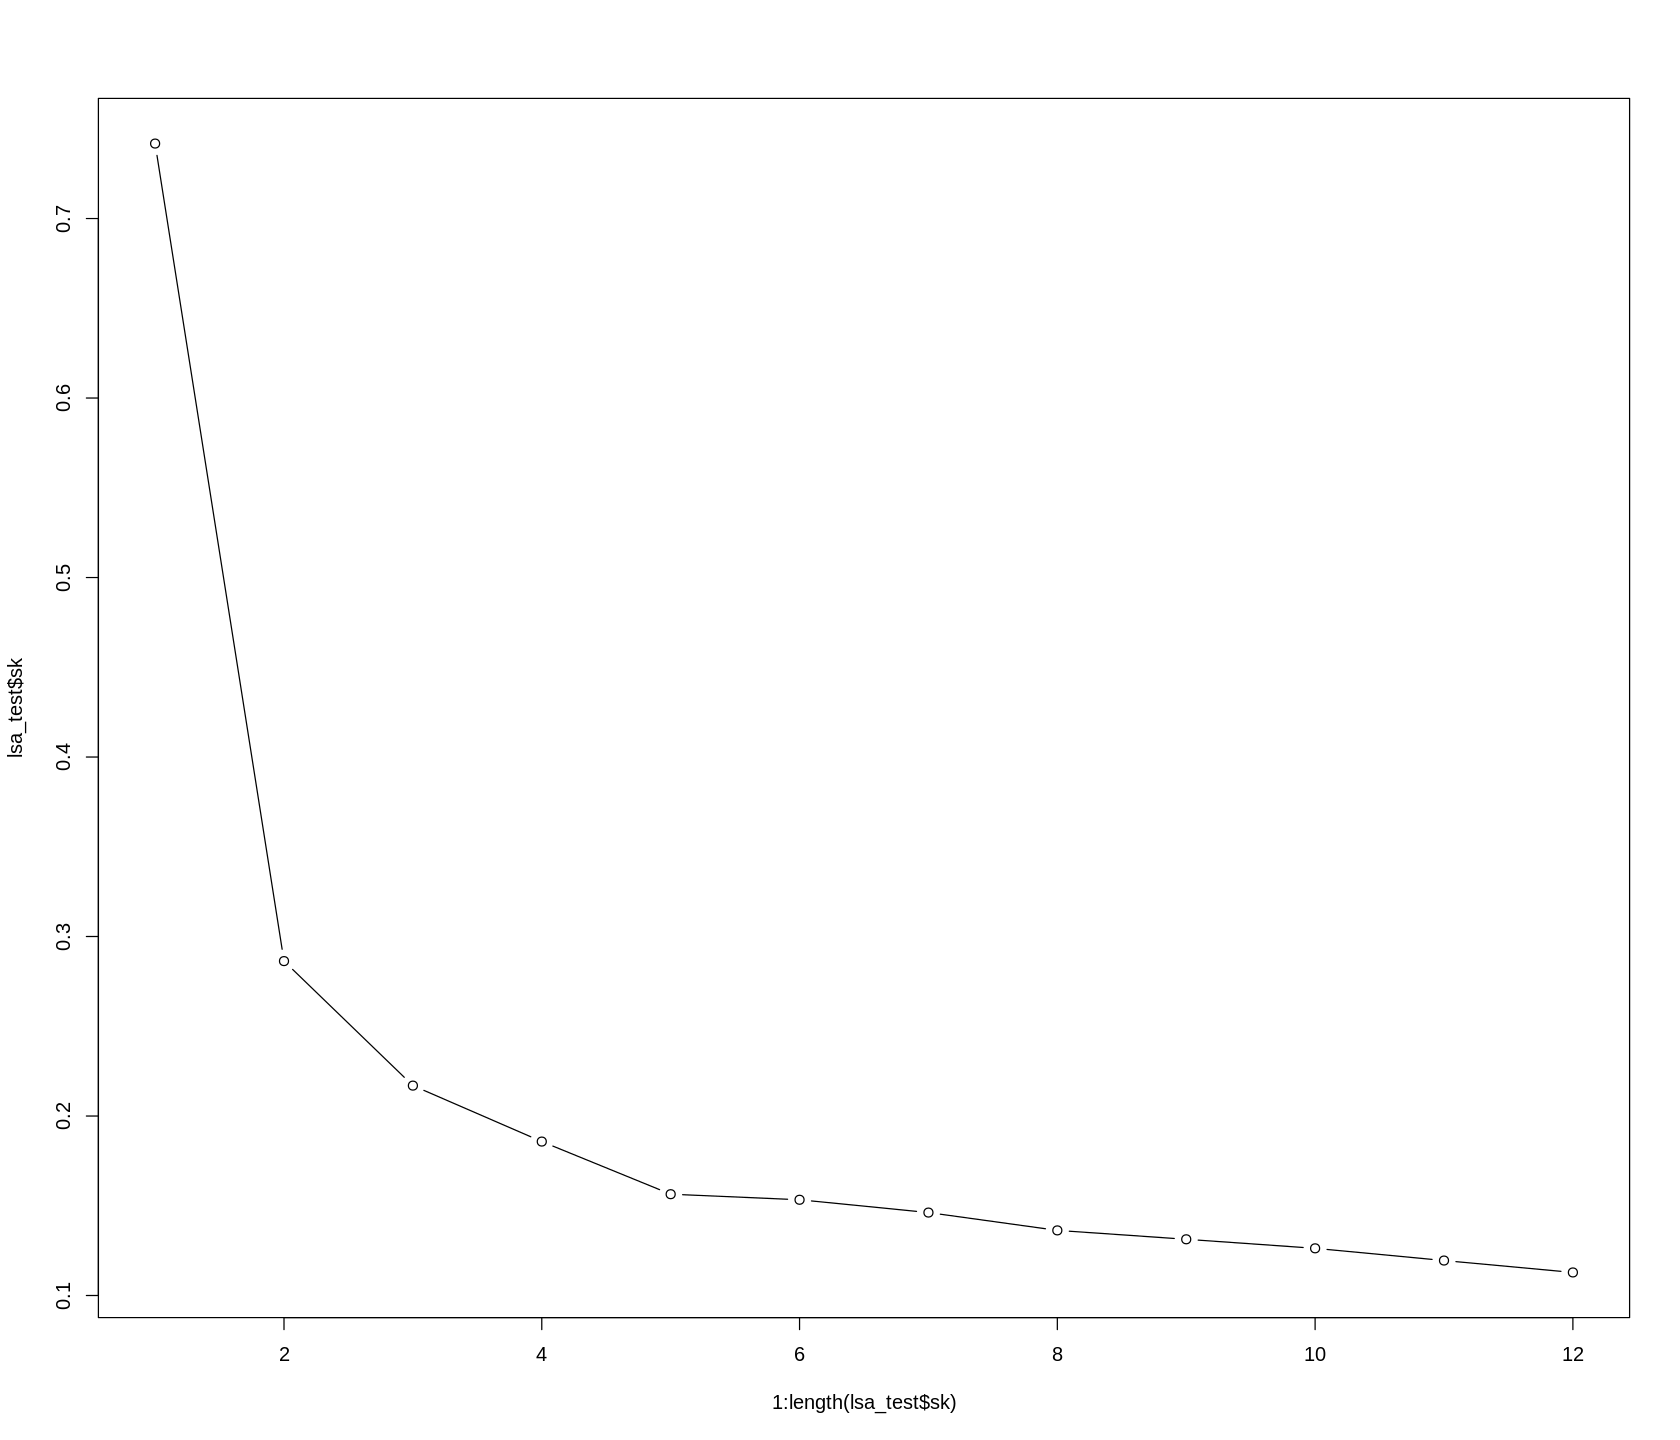

In [ ]:
plot(1:length(lsa_test$sk), lsa_test$sk, type='b')

In [ ]:
term_lsa <-lsa_test$tk %*% diag(lsa_test$sk)
doc_lsa <- lsa_test$dk %*% diag(lsa_test$sk)

In [ ]:
# compute the norm of each term
norma_termini_lsa_test <- apply(term_lsa, 1, normalize)

norm_ids <- length(lsa_test$sk) + 1 # column in which it is stored the norm value
tag_ids <- 1 

# build the apposite structures
tls_norma_termini_test = cbind(term_lsa, norma_termini_lsa_test)
tls_words_tag = cbind(test_words, norma_termini_lsa_test)

meaning_threshold <- 0.005
meaningful_terms <- subset(tls_norma_termini_tr_val, norma_termini_lsa_test > meaning_threshold)[,-norm_ids]
meaningful_words <- subset(tls_words_tag, norma_termini_lsa_test > meaning_threshold)[,tag_ids]

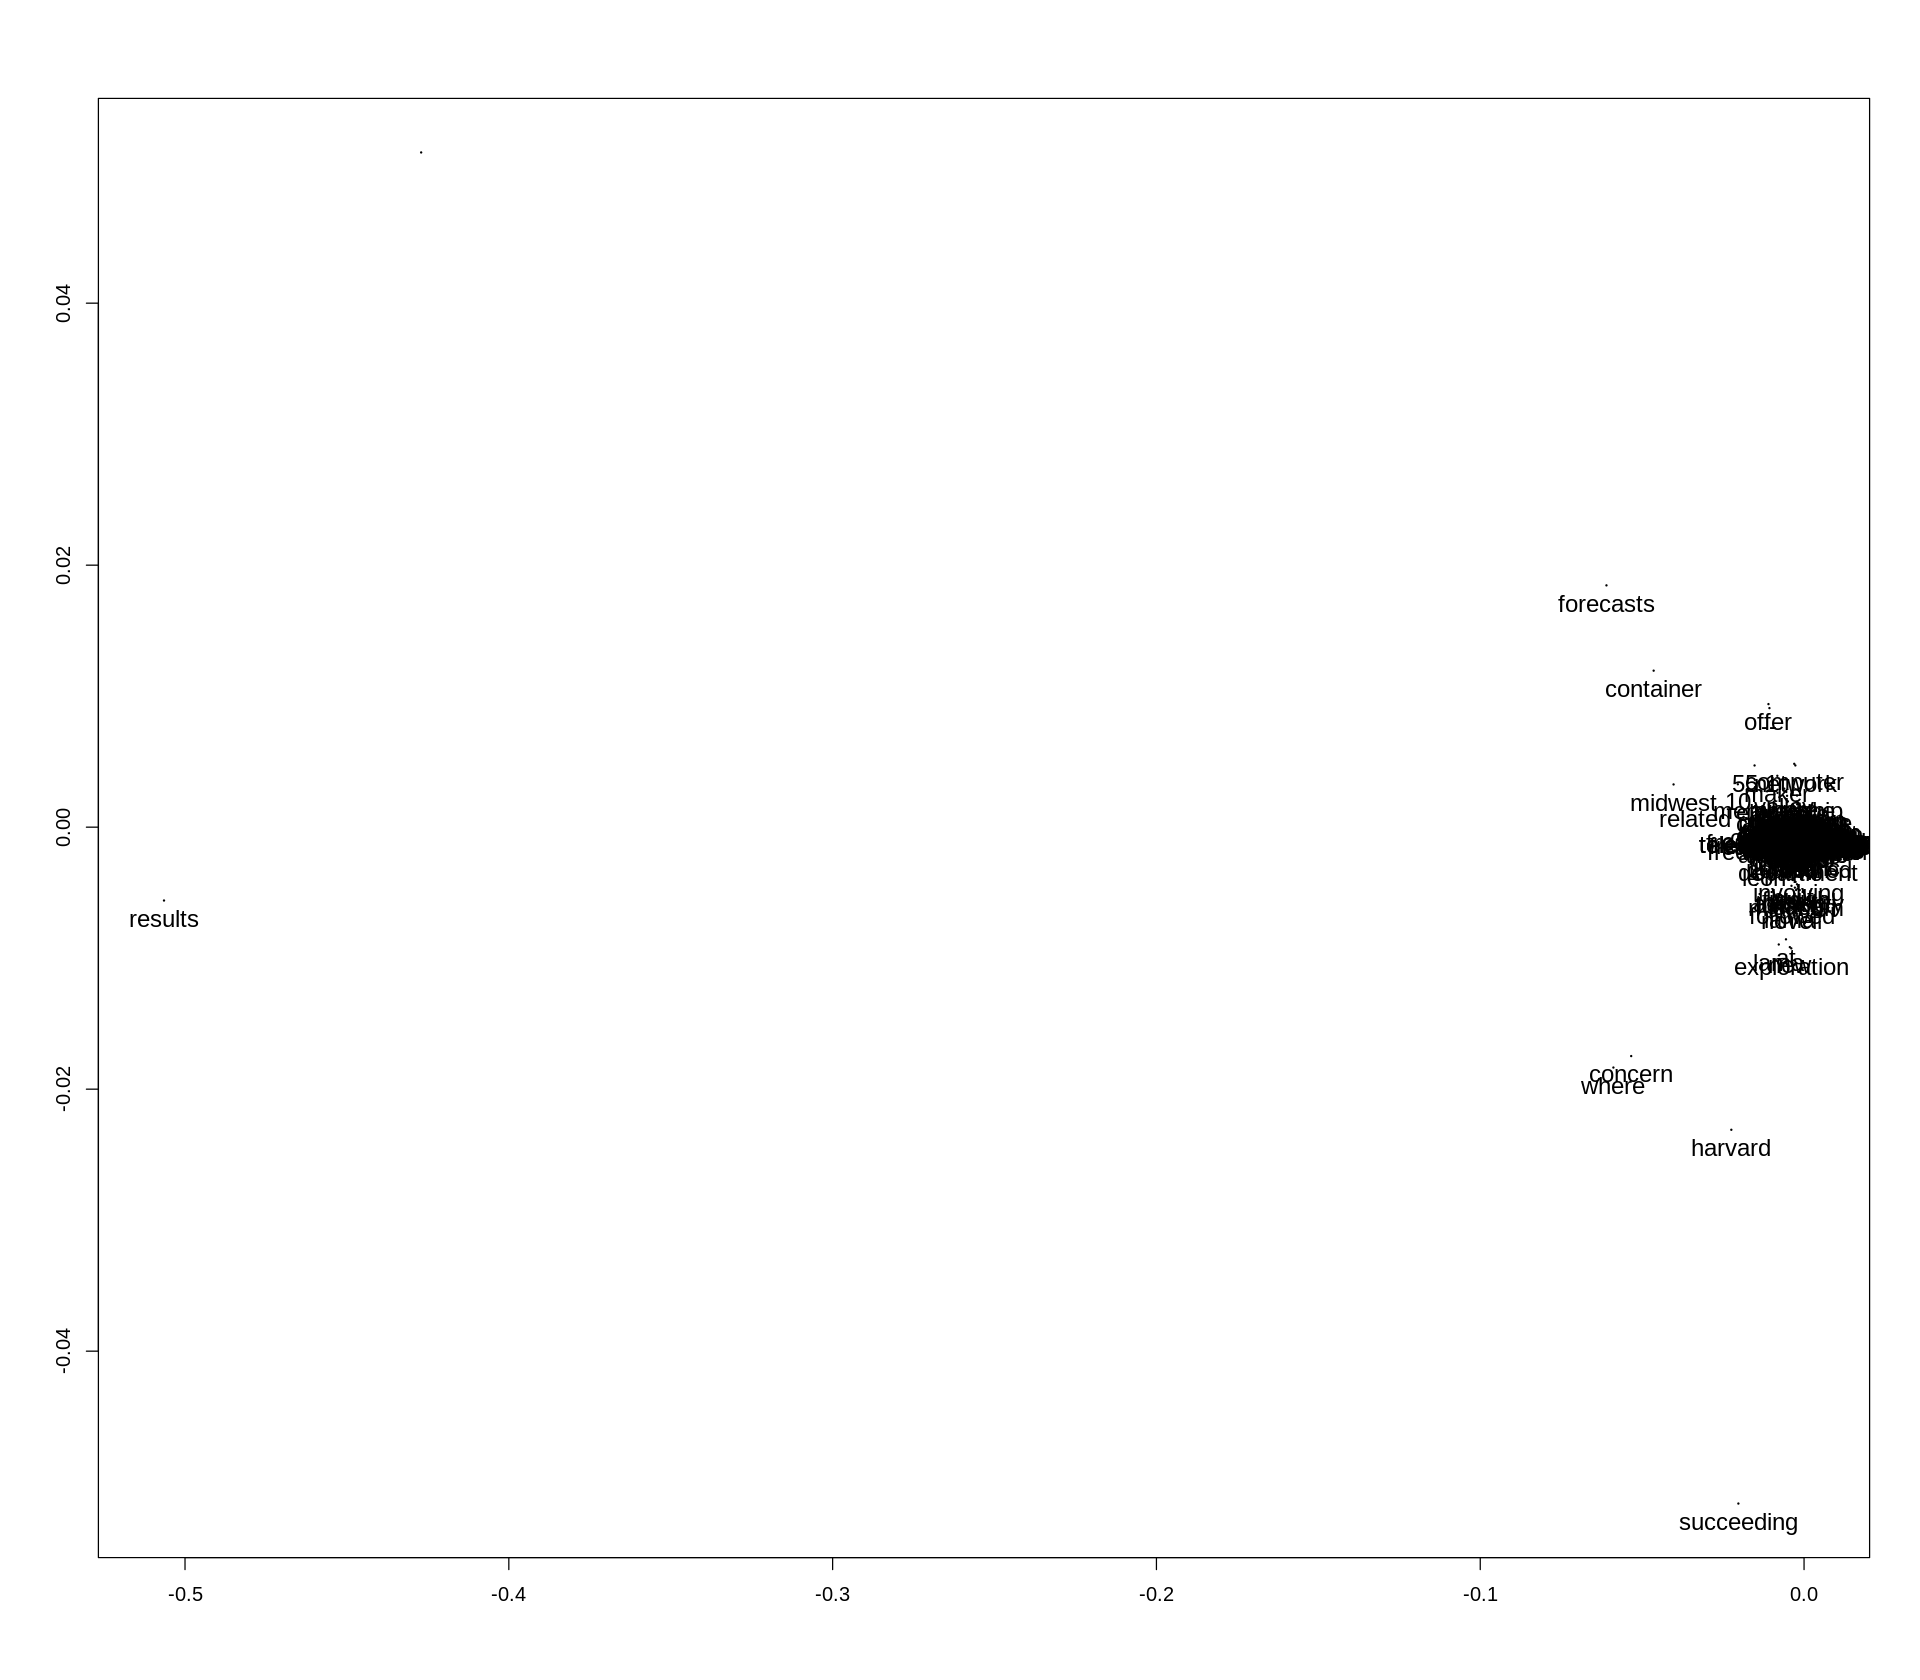

In [ ]:
options(repr.plot.width=16, repr.plot.height=14)
plot( meaningful_terms, pch=20, cex= 0.2)
text( meaningful_terms, labels=meaningful_words, cex=1.2, pos=1)

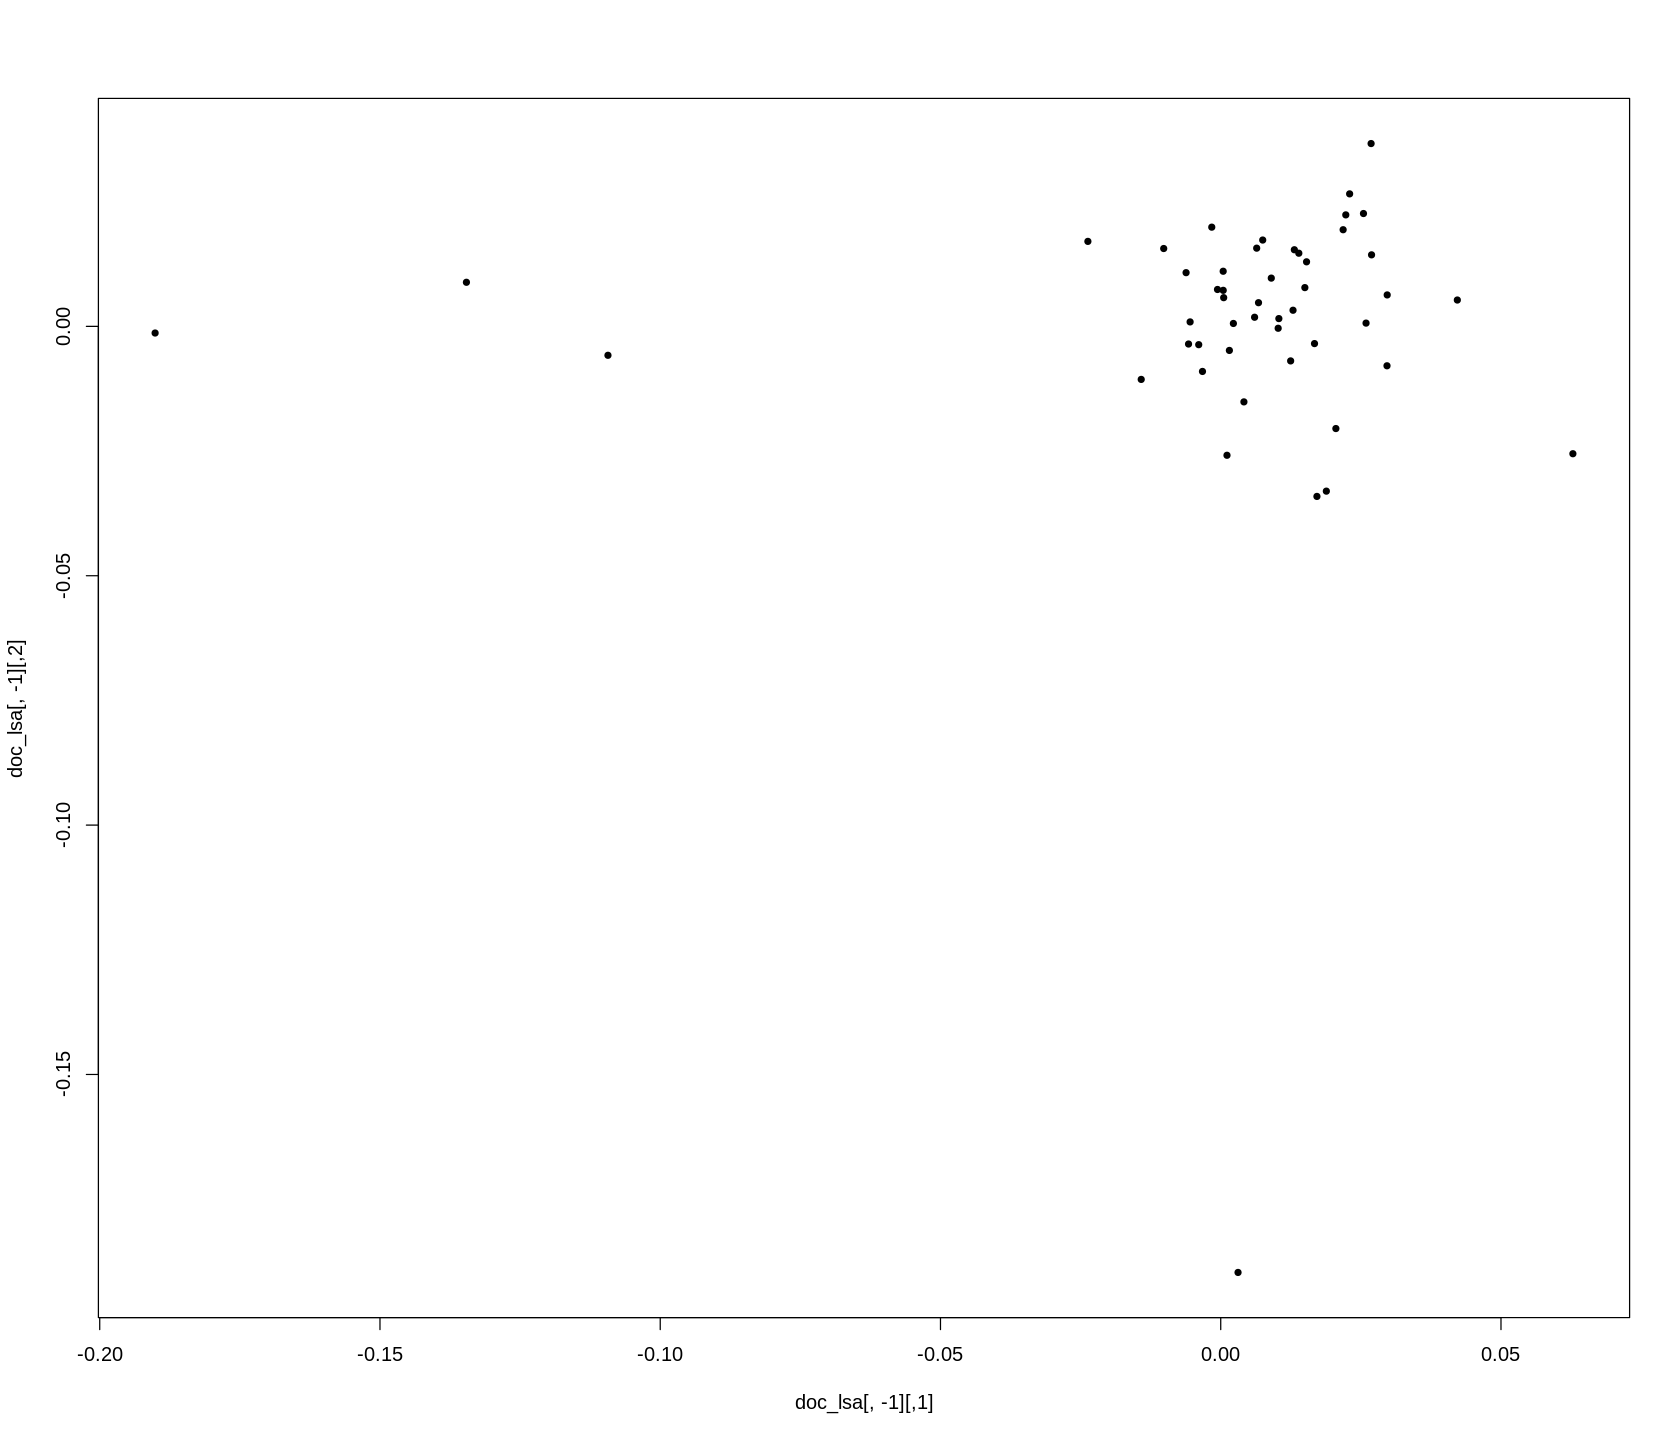

In [ ]:
options(repr.plot.width=14, repr.plot.height=12)
plot( doc_lsa[,-1], pch=20 ) # -1 removes the first latent dimensions in order to display 2° and 3°

In [ ]:
test_oov <- read_oov('oov_test.csv')
tst_oov_similarities <- lapply(test_oov,find_10_most_similar,term_lsa)

In [ ]:
head(tst_oov_similarities)

[[1]]
   1\\/2    7\\/8  derchin  capture response    176.1   remain    sense 
       1        1        1        1        1        1        1        1 
 bearing  release 
       1        1 

[[2]]
      popular       slaying        rebels         jihad         alert 
            1             1             1             1             1 
modernization          acid       retired        andean        anemic 
            1             1             1             1             1 

[[3]]
         11.95        shuttle      additions             49      excluding 
             1              1              1              1              1 
      positive     resumption printing-press           hits        singled 
             1              1              1              1              1 

[[4]]
   1\\/2    7\\/8  derchin  capture response    176.1   remain    sense 
       1        1        1        1        1        1        1        1 
 bearing  release 
       1        1 

[[5]]
 regardless  hackensack      limits designation       exxon   petroleum 
          1           1           1           1           1           1 
  indicator    remained      turned     1988-89 
          1           1           1           1 

[[6]]
        198         gas         txo      inland steelmakers     earning 
          1           1           1           1           1           1 
       15.5   unusually         ton         ltd 
          1           1           1           1

In [ ]:
csv_format = as.matrix(unlist(tst_oov_similarities), nrow = len(train_val_oov))
capture.output(csv_format, file = "test_oov_similarities.csv")

## RESULTS
The results for the train/validation and test sets are stored in the files "train_val_oov_similarities.csv" and "test_oov_similarities.csv", respectively